In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
dataset = datasets.load_iris()

In [3]:
# print(dataset.DESCR)

In [3]:
# взглянем на данные
ext_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, ext_target,
    dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [5]:
# форма данных
features = dataset.data
target = dataset.target
features.shape, target.shape

((150, 4), (150,))

## Своя реализация

нормальное или гауссовское распределение:
$$
f(x|\mu,\sigma^2)=\frac{1}{\sigma \sqrt{2\pi}} \exp{ \left( - \frac{(x-\mu)^2}{2\sigma^2} \right)}
$$
где $\sigma$  стандартное отклонение, а$\mu$ мат. ожидание

In [6]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
        feature: column of design matrix, represents all
        available values of features to model.
        axis=0 stays for samples.
        '''
        self.mean = np.mean(feature, axis=0)
        self.std = np.std(feature, axis=0)
    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return - 0.5 * np.log(2. * np.pi * self.std**2) - (value - self.mean)**2 / (2 * self.std**2)
    def pdf(self, value):
        return np.exp(self.logpdf(value)) 

In [7]:
import scipy
_test = scipy.stats.norm(loc=features[:, :2].mean(axis=0),scale=features[:, :2].std(axis=0))
assert np.allclose(
    GaussianDistribution(features[:, :2]).logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
)
print('Seems fine!')

Seems fine!


In [8]:
GaussianDistribution(features[:, :2]).logpdf(features[:5, :2])

array([[-1.13254506, -0.60435921],
       [-1.38017561, -0.09388356],
       [-1.68653276, -0.13910217],
       [-1.86173382, -0.08999759],
       [-1.24901951, -0.86542599]])

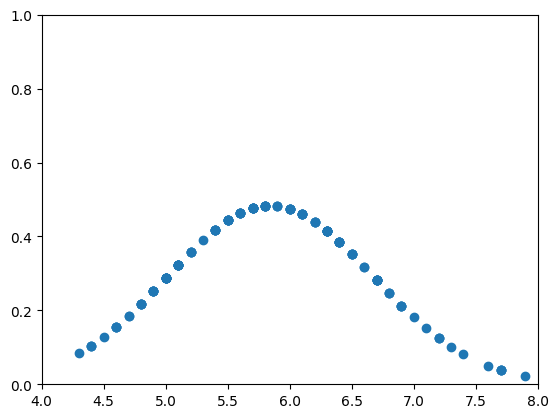

In [9]:
plt.axis([4, 8, 0, 1])
plt.scatter(features[:, 0],GaussianDistribution(features[:, :2]).pdf(features[:, :2])[:,0])

(array([ 9., 23., 14., 27., 16., 26., 18.,  6.,  5.,  6.]),
 array([4.3 , 4.66, 5.02, 5.38, 5.74, 6.1 , 6.46, 6.82, 7.18, 7.54, 7.9 ]),
 <BarContainer object of 10 artists>)

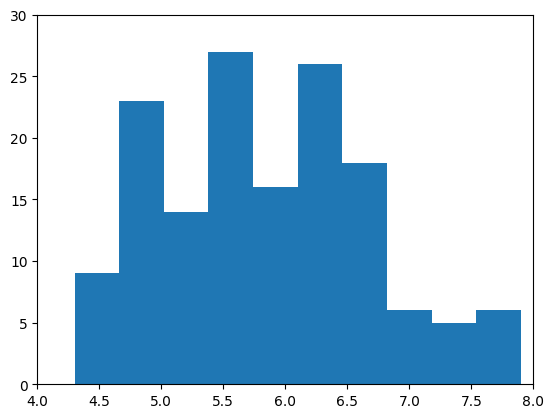

In [10]:
plt.axis([4, 8, 0, 30])
plt.hist(features[:, 0])

## Наивный Байесовский классификатор

**Наивные методы Байеса** — это алгоритм ML  обучения с учителем, основанных на применении теоремы Байеса с предположением об ***независимости между каждой парой признаков***.

Пусть наступившее событие - это набор признаков (feature vector $x_i=(x_i^1, x_i^2, \dots, x_i^n)$), а гипотетическое событие - значение метки класса (class label $y_i = C_k$) для некоторого образца $i \in (1, \dots ,m)$ и метки класса $C_k$. То в сответсвии с теоремой Байеса:

$$
P(y_i = C_k|x_i) = \frac{P(x_i|y_i = C_k) P(y_i = C_k)}{P(x_i)}
$$

В соответсвии с теоремой о произведении вероятности независимых событий:
 $$
 P(x_i|y_i = C_k) = \prod_{j=1}^{n}P(x_i^j|y_i = C_k)
 $$

Заменяем:

$$
P(y_i = C_k|x_i) = \frac{P(y_i = C_k) \prod_{j=1}^{n}P(x_i^j|y_i = C_k)}{P(x_i)}, где
$$

$$
P(x_i^j | y_i = C_k) = P(x_i^j | y_i = C_k, x_i^1, \dots, x_i^{i-1}, x_i^{i+1}, \dots, x_i^n)
$$

Ввиду того, что полная вероятность $P(x_i)$ является константой, и служит для нормирования, ее можно опустить и свести задачу к следующему виду:

$$
P(y_i = C_k|x_i) \propto P(y_i = C_k) \prod_{j=1}^{n}P(x_i^j|y_i = C_k)\\\Downarrow\\\hat{y} = \arg\max_{y_i = C_k} P(y_i = C_k) \prod_{j=1}^{n}P(x_i^j|y_i = C_k)
$$

Довольно часто используют логарифмы вероятностей. Тогда,

$$
\hat{y} = \arg\max_{y_i = C_k} ({\log P(y_i = C_k) + \sum_{j=1}^{n} \log P(x_i^j|y_i = C_k)})
$$

Различные наивные байесовские классификаторы строятся с учетом имперического предположения о распределении вероятности $P(x_i^j|y_i = C_k)$. Самое распространенное предположение относительно количественных признаков заключается в том, что *распределение каждого признака подчиняется закону Гаусса*. Т.о,

$$
P(x_i^j|y_i = C_k) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x_i^j - \mu )^2}{2\sigma^2}\right), где
$$

$$\mu = \frac{1}{n} \sum_{i=1}^m x_i^j,$$

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^m (x_i^j - \mu)}.$$

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight The argument is ignored. For compatibility only.
        '''
        self.unique_labels = np.unique(y)
        # если распределения не указано, используем Гауссовское
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            #Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]
        # Here we find distribution parameters for every features in every class subset
        # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
        self.conditional_feature_distributions = {} #Label: [distribution for feature 1, …]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # значения фичей column_index  для объектов класса label 
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution
            # Prior label distributions (unconditional probability of each class)
        self.prior_label_distribution = {
            label: sum((y==label).astype(float)) / len(y) for label in self.unique_labels
        }
    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)),dtype=float)
        # Here we compute the class log probabilities for each class sequentially b
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label
                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx]) 
            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distribution[label]) 
        for idx in range(X.shape[1]):
        # If you want to get probabilities, you need to subtract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1) [:, None] 
        return class_log_probas
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # We need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

Смотрим пример

In [12]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]


Проверяем

In [13]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)
print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [14]:
nb = NaiveBayes()
nb.fit(features_train, target_train,distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [15]:
print('Точность:{}'.format(nb.score(features_test, target_test)))

Точность:0.9473684210526315


### NB Scikit Learn

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [17]:
baes_model = GaussianNB()
baes_model.fit(features_train, target_train)

GaussianNB()

In [18]:
print('Точность:{}'.format(baes_model.score(features_test, target_test)))

Точность:0.9473684210526315


### А как там у соседей? Применим KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(features_train, target_train)
knn_model.score(features_test, target_test)

0.9736842105263158